In [16]:
import matplotlib.pyplot as plt
import torch.utils.data 
from torch.utils.data import ConcatDataset

In [17]:
from torchvision import transforms, datasets

data_dir = '../data/flower/'

batch_size = 5

size = 512

apply_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
])

trainset = datasets.Flowers102(data_dir, split='train', transform=apply_transform, download=True)
testset = datasets.Flowers102(data_dir, split='test', transform=apply_transform, download=True)
# trainset, valset = torch.utils.data.random_split(trainset, [int(0.9 * len(trainset)), int(0.1 * len(trainset))])
valset = datasets.Flowers102(data_dir, split='val', transform=apply_transform, download=True)

full_trainset = ConcatDataset([trainset, valset])


In [18]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

train_iter = iter(trainset)
image, label = next(train_iter)
image.shape, label, torch.min(image).item(), torch.max(image).item()

(torch.Size([3, 512, 512]), 0, 0.0, 0.9058823585510254)

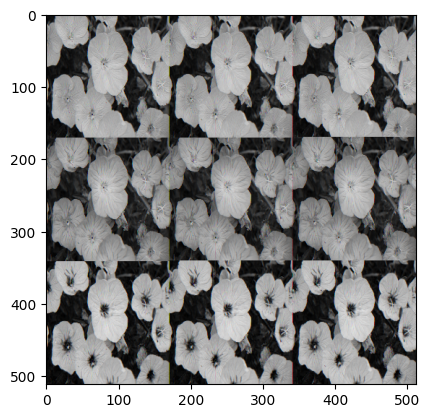

In [19]:
ar = image.numpy()
plt.imshow(ar.reshape((size, size, 3)))

In [20]:
len(trainset), len(testset)

(1020, 6149)

In [21]:
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
# valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class CNNFlower(nn.Module):
    def __init__(self):
        super(CNNFlower, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 12, 3)
        self.conv2 = nn.Conv2d(12, 24, 3)
        self.conv3 = nn.Conv2d(24, 24, 3)
        self.conv4 = nn.Conv2d(24, 32, 2)
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(24 * 62 * 62, 256)
        self.drop1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, 128)
        self.drop2 = nn.Dropout(0.2)
        self.out = nn.Linear(128, 102)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        # x = F.relu(self.conv4(x))
        # x = self.pool(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.drop1(x)        

        x = F.relu(self.fc2(x))
        x = self.drop2(x)

        x = self.out(x)

        return x

In [23]:
net = CNNFlower()
net.to(device)

CNNFlower(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(24, 32, kernel_size=(5, 5), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=28800, out_features=1024, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (drop2): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=512, out_features=102, bias=True)
)

In [24]:
# for i, data in enumerate(trainloader):
#     inputs, labels = data[0].to(device), data[1].to(device)
#     print(f'inputs: {inputs.shape}')
#     print(f'after network shape: {net(inputs).shape}')
#     break

In [25]:
num_params = 0
for x in net.parameters():
    num_params += len(torch.flatten(x))
print(f'Number of parameters: {num_params:,}')  # 19,248,934

Number of parameters: 30,096,742


In [26]:
from sklearn.model_selection import KFold

k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

def get_fold_data(fold_index):
    train_indices, val_indices = list(kf.split(range(len(full_trainset))))[fold_index]
    train_subset = torch.utils.data.Subset(full_trainset, train_indices)
    val_subset = torch.utils.data.Subset(full_trainset, val_indices)
    return train_subset, val_subset

In [27]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [28]:
def train_one_epoch(trainloader):
    net.train(True)
    running_loss = 0.0
    running_accuracy = 0.0
    
    for batch_index, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)  # shape (batch_size, 102)
        correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        running_accuracy += correct / batch_size
        
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if batch_index % batch_size == batch_size - 1:  # print every x batches
            avg_loss = running_loss / batch_size
            avg_accuracy = (running_accuracy / batch_size) * 100
            print('Batch {0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index + 1, avg_loss, avg_accuracy))
            running_loss = 0.0
            running_accuracy = 0.0

In [29]:
def validate_one_epoch(valloader):
    net.train(False)
    running_loss = 0.0
    running_accuracy = 0.0
    
    for i, data in enumerate(valloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        with torch.no_grad():
            outputs = net(inputs)
            correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += correct / batch_size
            loss = criterion(outputs, labels)  # one number, the average batch loss
            running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        
    avg_loss = running_loss / len(valloader)
    avg_acc = (running_accuracy / len(valloader)) * 100
    
    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss, avg_acc))
    print('-----------------------------------')

In [30]:
num_epochs = 9

for fold_index in range(k):
    print(f'Fold {fold_index + 1}\n')
    for epoch_index in range(num_epochs):
        print(f'Epoch {epoch_index + 1}\n')
        train_subset, val_subset = get_fold_data(fold_index)
        trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
        valloader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
        
        train_one_epoch(trainloader)
        validate_one_epoch(valloader)

loss, correct, total = 0.0, 0.0, 0.0
for batch_idx, (images, labels) in enumerate(testloader):
    images, labels = images.to(device), labels.to(device)

    # Inference
    outputs = net(images)
    batch_loss = criterion(outputs, labels)
    loss += batch_loss.item()

    # Prediction
    # _, pred_labels = torch.max(outputs, 1)
    # pred_labels = pred_labels.view(-1)
    correct += torch.sum(labels == torch.argmax(outputs, dim=1)).item()
    total += len(labels)

print(f'Final accuracy: {100*correct/total}')

print('Finished Training')

print('Finished Training')

Fold 1

Epoch 1
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\Matei\PycharmProjects\Federated-Learning-PyTorch\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Matei\AppData\Local\Temp\ipykernel_27452\3255853754.py", line 11, in <module>
    train_one_epoch(trainloader)
  File "C:\Users\Matei\AppData\Local\Temp\ipykernel_27452\117211088.py", line 6, in train_one_epoch
    for batch_index, data in enumerate(trainloader):
  File "C:\Users\Matei\PycharmProjects\Federated-Learning-PyTorch\.venv\lib\site-packages\torch\utils\data\dataloader.py", line 631, in __next__
    data = self._next_data()
  File "C:\Users\Matei\PycharmProjects\Federated-Learning-PyTorch\.venv\lib\site-packages\torch\utils\data\dataloader.py", line 1346, in _next_data
    return self._process_data(data)
  File "C:\Users\Matei\PycharmProjects\Federated-Learning-PyTorch\.venv\lib\site-packages\torch\utils\data\dataloader.py", l